# **Information on data acquisition and chosen interaction paradigms**
## **Data Acquisition**
* **No electromagnetic shielding or artifact control** was attempted for the recordings.
* Out of 22 channels used, the 2 ground leads are labeled $A_1$ and $A_2$. $X_3$ is used for data synchronization.
* Hardware filters of $0.53 - 70 Hz$ and $0.53 - 100 Hz$ are applied for EEG data recorded at sampling rates of $200 Hz$ and $1000 Hz$ respectively.
* A $50Hz$ notch filter is also applied to reduce electrical grid interference.
* **No terminal motion and E&M-related interference** occurred during data collection.
* **All electrode impedances were below specified levels** at the start and end of the recording session, and no other technical issues were present.
* **Post-hoc modifications** of data of any kinds were **not applied** to present researchers with the raw-est data possible.

## **NoMT interaction paradigm**
* **General description**: Similar to HaLT where 6 mental imageries of passive, left and right-hand, left and right-leg, and toungue movements are implemented but the participants were not asked to react to any visual signals appearing on the eGUI screen and this passively watched the computer screen for the duration of the recording session.
* Participants are given 2.5 minutes at the beginning to acclimatize to the recording session's conditions.
* Afterwards, each interaction segment is administered for 15 minutes.
* 3 BCI interation segments, each with a 2-minute break, form one recording session. During the rest period, participants were **allowed to talk or move** in their chair. The EEG data was continously recorded during rest periods as well. <br>
$\rightarrow$ **EEG data is continuously measured for a total length of 50 - 55 minutes**
* Each segment consisted of **a series of BCI interaction trials** in which a visual action signal was shown on eGUI screen to evoke some mental image.
* The signal **remains for $1s$** during which time the participant implemented the given mental imagery.
* Afterwards, the random duration **off-time of $1.5 - 2.5s$** followed, concluding the trial.

# **I. Environment setups**

In [26]:
import os
os.chdir('c:\\Users\\LENOVO\\Desktop\\Lab\\MotorImageryEEG')

In [29]:
# Necessary libraries
from typing import List, Literal
from scipy.io import loadmat
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import regex as re
import gc
import mne
%matplotlib inline

# Supporting functions and classes
from Utilities import *
from DataFile import DataFile
from FeatureExtractor import extract_WT_power

# For building, training and evaluating model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense, InputLayer, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Constants
BATCH_SIZE=64
N_CLASSES = 7
CLASS_LABELS = ["Subject F", "Subject H", "Subject I", "Subject J", "Subject K", "Subject L", "Subject M"]

# **II. Data extraction and formatting**

In [5]:
files = [
    'data\\NoMTSubjectF1604220StNoMotor.mat',
    'data\\NoMTSubjectH1606280StNoMotor.mat',
    'data\\NoMTSubjectI1605120StNoMotor.mat',
    'data\\NoMTSubjectJ1610260StNoMotor.mat',
    'data\\NoMTSubjectK1610250StNoMotor.mat',
    'data\\NoMTSubjectL1610260StNoMotor.mat',
    'data\\NoMTSubjectM1611160StNoMotor.mat'
]

In [ ]:
datasets = []
for file in files:
  dataset = DataFile(file_path = file)
  dataset.generate()
  datasets.append(dataset)

Creating RawArray with float64 data, n_channels=22, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=734400
    Range : 0 ... 734399 =      0.000 ...  3671.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=678400
    Range : 0 ... 678399 =      0.000 ...  3391.995 secs
Ready.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\772564301.py:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


# **III.Preprocessing**

## **1. Filtering**
* **ECG artifacts** primarily exist in the $0 - 50Hz$ frequency range, with the strongest component typically below $1 - 2Hz$ due to slow waveforms of cardic activity.
* **EOG artifacts** are often in the $0 - 10Hz$ frequency range with the most dominant components in the $0 - 4Hz$ range. <br>
$\rightarrow$ **Unwise to apply any bandpass filter before running ICA for artifact correction. Interested signals in specific frequency band should be extracted later.**

## **2. Re-referencing**

The reference point for all recording was "System 0 V" as defined by the EEG-1200's technical manual at $0.55 \times (C_3 + C_4)V$

## **3. Artifact detection and correction**
* With no ECG or EOG channels, artifact-related methods provided by **MNE-Python** are rendered useless. Attempts to generate **synthetic EOG and ECG channels** have proven to be ineffective.
* We have to build a method from sratch if only EEG channels are used to correct EOG and ECG artifacts. For now, this process is skipped!

# **IV. Feature Extraction**

## **1. Epoching data**

In [7]:
epochs_list = []
for i in range(len(datasets)):
  format_data = datasets[i].format_data
  events, event_id = mne.events_from_annotations(format_data)
  epochs = mne.Epochs(format_data, events, event_id,
                      tmin = -0.5, tmax = 1.5,
                      baseline = (None, 0), preload = True)
  subject = epochs.info["subject_info"]["his_id"]
  measurement_date = epochs.info["meas_date"]
  epochs.metadata = pd.DataFrame({"Subject" : [subject] * len(epochs),
                                  "Measurement Date" : [measurement_date] * len(epochs),
                                  "Class" : [i] * len(epochs)})
  epochs_list.append(epochs)

Used Annotations descriptions: ['blank', 'left hand', 'left leg', 'passive or neutral', 'right hand', 'right leg', 'tongue']
Not setting metadata
1917 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1917 events and 401 original time points ...
9 bad epochs dropped
Adding metadata with 3 columns
Used Annotations descriptions: ['blank', 'left hand', 'left leg', 'passive or neutral', 'right hand', 'right leg', 'tongue']
Not setting metadata
1905 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1905 events and 401 original time points ...
9 bad epochs dropped
Adding metadata with 3 columns
Used Annotations descriptions: ['blank', 'left hand', 'left leg', 'passive or neutral', 'right hand', 'right leg', 'tongue']
Not setting metadata
1911 matching even

In [8]:
# Combine all epoch together
combined_epochs = mne.concatenate_epochs(epochs_list)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12720\917416234.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_epochs = mne.concatenate_epochs(epochs_list)


Adding metadata with 3 columns
13356 matching events found
Applying baseline correction (mode: mean)


## **2. Splitting epochs into training and test set**

In [124]:
idx = np.arange(len(combined_epochs))
y = np.array(combined_epochs.metadata["Class"])
train_val_idx, test_idx, y_train_val, y_test = train_test_split(
    idx, y, test_size = 0.2, stratify = y, random_state = 0
)
train_val_idx.shape, test_idx.shape

((10684,), (2672,))

In [125]:
train_val_epochs = combined_epochs[train_val_idx]
test_epochs = combined_epochs[test_idx]

## **3. K-fold cross-validation**

**Notes**: *Run the below cell 1 time to generate the extracted features*

In [ ]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
# Checkpoint to create the training data after K-fold cross-validation
create_final_train_data = True

# Create storing directories
os.makedirs("data\\wavelet_features\\final_train")
os.makedirs("data\\wavelet_features\\test")
for i, (train_idx, val_idx) in enumerate(kfold.split(train_val_epochs, y_train_val)):
  directory = f"data\\wavelet_features\\fold_{i+1}"
  os.makedirs(directory)
  
  train_epochs, val_epochs = train_val_epochs[train_idx], train_val_epochs[val_idx]
  # Validation targets
  y_val = y_train_val[val_idx]
  np.save(f"{directory}\\val_target.npy", y_val.astype(np.int8))
  # Add Gaussian noise to our train data only
  noisy_epochs = add_gaussian_noise(train_epochs)
  # Double our training data with the noisy epochs and shuffle them
  noisy_train_epochs = mne.concatenate_epochs([train_epochs, noisy_epochs])
  shuffled_epochs = shuffle_epochs(noisy_train_epochs)
  # Train targets
  y_train = np.array(shuffled_epochs.metadata["Class"])
  np.save(f"{directory}\\train_target.npy", y_train.astype(np.int8))
  # Paths to train features and validation features
  extract_WT_power(shuffled_epochs, 
                   directory=directory, 
                   save_prefix="train")
  extract_WT_power(val_epochs, 
                   directory=directory, 
                   save_prefix="validation")

  if create_final_train_data:
    final_train_epochs = mne.concatenate_epochs([noisy_train_epochs, val_epochs])
    final_train_epochs = shuffle_epochs(final_train_epochs)
    y_final_train = np.array(final_train_epochs.metadata["Class"])
    np.save("data\\wavelet_features\\final_train\\train_target.npy", y_final_train.astype(np.int8))
    extract_WT_power(final_train_epochs, 
                     directory="data\\wavelet_features\\final_train", 
                     save_prefix="final_train")
    create_final_train_data = False

In [126]:
extract_WT_power(test_epochs, directory="data\\wavelet_features\\test", save_prefix="test")
np.save("data\\wavelet_features\\test\\test_target.npy", y_test.astype(np.int8))

Processing epochs 0 to 1000
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Processing epochs 1000 to 2000
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Processing epochs 2000 to 2672
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


## **4. Load data from batches for model training**

In [14]:
kfold_train_paths = [[f"data\\wavelet_features\\fold_{j+1}\\train\\batch_{i+1}.npy" for i in range(18)] for j in range(5)]
kfold_val_paths = [[f"data\\wavelet_features\\fold_{j+1}\\validation\\batch_{i+1}.npy" for i in range(3)] for j in range(5)]
kfold_y_train = [np.load(f"data\\wavelet_features\\fold_{i+1}\\train_target.npy") for i in range(5)]
kfold_y_val = [np.load(f"data\\wavelet_features\\fold_{i+1}\\val_target.npy") for i in range(5)]
final_train_paths = [f"data\\wavelet_features\\final_train\\batch_{i+1}.npy" for i in range(20)]
y_final_train = np.load(f"data\\wavelet_features\\final_train\\train_target.npy")
test_paths = [f"data\\wavelet_features\\test\\batch_{i+1}.npy" for i in range(3)]
y_test = np.load("data\\wavelet_features\\test\\test_target.npy")

# **V. Training model**

## **1. Dataset**

In [ ]:
def sample_generator(data_paths : list, labels : np.array):
  """
  Generate one sample at a time from all files specified by data_paths
  Due to RAM limitation, we have to split all raw EEG epochs into batches and extract WT features for them CONSECUTIVELY.
  Each batch is saved into .npy files right after extraction and memory is released.

  Parameters:
  ----------
  data_paths : list
    A list of file directories containing the WT features of epoch batches
  labels : np.array
    The target vectors for ALL epochs (samples)
  
  Return:
  ----------
    Our sample generator of <class 'generator'>
  """
  def generator():
    sample_idx = 0
    for path in data_paths:
      data = np.load(path)
      data_size = len(data)
      data_labels = labels[sample_idx:(sample_idx + data_size)]
      for sample, label in zip(data, data_labels):
        yield sample, label
      sample_idx += data_size
  return generator

In [ ]:
def create_dataset(data_paths : list, labels : np.array, batch_size = BATCH_SIZE, shuffle = False) -> tf.data.Dataset:
  """
  Create the type of dataset that can generate samples in each batch to train on the fly

  Parameters:
  ---------
  data_paths : list
    A list of file directories containing the WT features of epoch batches
  labels : np.array
    The target vectors for ALL epochs (samples)
  batch_size : int
    The number of data batches ready for training, default is 64
  shuffle : boolean
    Shuffle each batch in each training iteration, defaul to False
  
  Returns:
  ----------
  tf.data.Dataset
    The dataset ready for model fitting
  """
  output_signature = (
      tf.TensorSpec(shape = (18, 134, 21), dtype = tf.float32),
      tf.TensorSpec(shape = (), dtype = tf.int32)
  )
  ds = tf.data.Dataset.from_generator(
      sample_generator(data_paths, labels),
      output_signature = output_signature
  )
  if shuffle:
    ds = ds.shuffle(buffer_size = 5000, reshuffle_each_iteration = True)

  ds = ds.map(lambda X, y: (z_normalize(X), y), num_parallel_calls = tf.data.AUTOTUNE)
  ds = ds.batch(batch_size, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
  return ds

## **2. Model**

In [ ]:
def generate_model(n_filters : int, n_units : int, input_shape = (18, 134, 21), num_classes = N_CLASSES) -> tf.keras.Sequential:
    """ 
    Build the CNN model with 2 convolutional layers followed by 2 dense layers, each with one dropout layer.
    
    Parameters:
    ----------
    n_filters : int
        The number of CNN filters in the convolutional layer
    n_units : int
        The number of units in the dense layer
    input_shape : tuple
        Shape of the input as a WT-feature epoch in form (n_frequencies, n_times, n_channels), default is (18, 134, 21)
    num_classes : int
        The number of classes to classifiy
    
    Returns:
    ----------
    tf.keras.Sequential
        The built CNN model

    """
    model = Sequential([
        InputLayer(shape = input_shape),

        Conv2D(n_filters, kernel_size=(3, 3), activation = "relu", padding = "same"),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(n_filters * 2, kernel_size = (3, 3), activation = "relu", padding = "same"),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(n_units, activation = "relu", kernel_regularizer=l2()),
        Dropout(0.3),
        Dense(n_units // 2, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation = "softmax")
    ])

    model.compile(
        optimizer = Adam(),
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )

    return model

## **3. Hyperparameter fine-tuning**

In [ ]:
param_grid = {
    'n_filters': [32, 64],
    'n_units': [32, 64, 128],
}

In [ ]:
best_score = -np.inf
# Create a directory to save the model's checkpoint
checkpoints_dir = "classifiers\\CNN_checkpoints"
for i in range(5):
    os.makedirs(checkpoints_dir + f"\\fold_{i+1}", exist_ok=True)

for params in ParameterGrid(param_grid):
    print(f"Parameters: {params}")
    train_accs = []
    val_accs = []

    for i in range(5):
        train_ds = create_dataset(kfold_train_paths[i], kfold_y_train[i])
        train_ds = train_ds.repeat()
        val_ds = create_dataset(kfold_val_paths[i], kfold_y_val[i])
        val_ds = val_ds.repeat()
        model = generate_model(**params)

        early_stop = EarlyStopping(monitor="val_loss", 
                                   patience = 3, 
                                   restore_best_weights=True)
        
        lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                        patience=2,
                                        verbose=0,
                                        factor=0.5,
                                        min_lr=0.00001)
        
        fold_dir = checkpoints_dir + f"\\fold_{i+1}"
        checkpoint_path = os.path.join(fold_dir, 
                                   f"fold_{i+1}_model_f{params['n_filters']}_u{params['n_units']}.weights.h5")
        checkpoint = ModelCheckpoint(checkpoint_path,
                                     monitor="val_loss",
                                     save_best_only=True,
                                     save_weights_only=True)
        
        history = model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 20,
                            steps_per_epoch = len(kfold_y_train[i]) // BATCH_SIZE,
                            validation_steps = len(kfold_y_val[i]) // BATCH_SIZE,
                            callbacks = [early_stop, lr_reduction, checkpoint], 
                            verbose=0)
        
        train_loss, train_acc = model.evaluate(train_ds, 
                                               steps = len(kfold_y_train[i]) // BATCH_SIZE, 
                                               verbose=0)
        val_acc = history.history["val_accuracy"][-1]
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Fold {i+1}: train accuracy = {train_acc:.6f}, validation accuracy = {val_acc:.6f}")
    mean_val_acc = np.mean(val_accs)
    print(f"Training accuracy: {np.mean(train_accs):.4f} ± {np.std(train_accs)}")
    print(f"Validation accuracy: {mean_val_acc:.4f} ± {np.std(val_accs)}")

    # Save the best configuration
    if mean_val_acc > best_score:
        best_score = mean_val_acc
        best_params = params
        best_fold_idx = np.argmax(val_accs)
        best_fold_dir = checkpoints_dir + f"fold_{best_fold_idx+1}"
        best_checkpoint_path = os.path.join(
            best_fold_dir, f"fold_{best_fold_idx+1}_model_f{best_params['n_filters']}_u{best_params['n_units']}.weights.h5"
        )

In [200]:
print(f"Best hyperparameteres: {best_params}")
print(f"Best checkpoint path: {best_checkpoint_path}")


Best hyperparameteres: {'n_filters': 64, 'n_units': 128}
Best checkpoint path: CNN_checkpoints\fold_2_model_f64_u128.weights.h5


In [ ]:
# Check for overfitting
best_kfold_model = generate_model(n_filters=64, n_units=128)
best_kfold_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 134, 64)    │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 134, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 67, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 67, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 67, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 33, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16896)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,162,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,258,311 (8.61 MB)

 Trainable params: 2,257,927 (8.61 MB)

 Non-trainable params: 384 (1.50 KB)

**Notes**: *I forgot to save the history of the K-fold model with the best params and best weights. Here, I train the model again with the best params on the fold with the best validation accuracy.*

In [ ]:
second_fold = create_dataset(kfold_train_paths[1], kfold_y_train[1])
second_fold = second_fold.repeat()
fold_val = create_dataset(kfold_val_paths[1], kfold_y_val[1])
fold_val = fold_val.repeat()

early_stop = EarlyStopping(monitor="val_loss", 
                            patience = 3, 
                            restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=2,
                                verbose=0,
                                factor=0.5,
                                min_lr=0.00001)

best_history = best_kfold_model.fit(second_fold,
                    validation_data = fold_val,
                    epochs = 20,
                    steps_per_epoch = len(kfold_y_train[1]) // BATCH_SIZE,
                    validation_steps = len(kfold_y_val[1]) // BATCH_SIZE,
                    callbacks = [early_stop, lr_reduction], 
                    verbose=1)

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 64s 240ms/step - accuracy: 0.9763 - loss: 0.5946 - val_accuracy: 0.9867 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 62s 231ms/step - accuracy: 0.9859 - loss: 0.4247 - val_accuracy: 0.8480 - val_loss: 1.1669 - learning_rate: 0.0010
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 62s 231ms/step - accuracy: 0.9890 - loss: 0.4090 - val_accuracy: 0.9830 - val_loss: 0.3958 - learning_rate: 0.0010
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 63s 236ms/step - accuracy: 0.9845 - loss: 0.4639 - val_accuracy: 0.9891 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 65s 243ms/step - accuracy: 0.9908 - loss: 0.3290 - val_accuracy: 0.9905 - val_loss: 0.3431 - learning_rate: 0.0010
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 58s 218ms/step - accuracy: 0.9955 - loss: 0.2510 - val_accuracy: 0.9834 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 64s 239ms/step - accuracy: 0.9

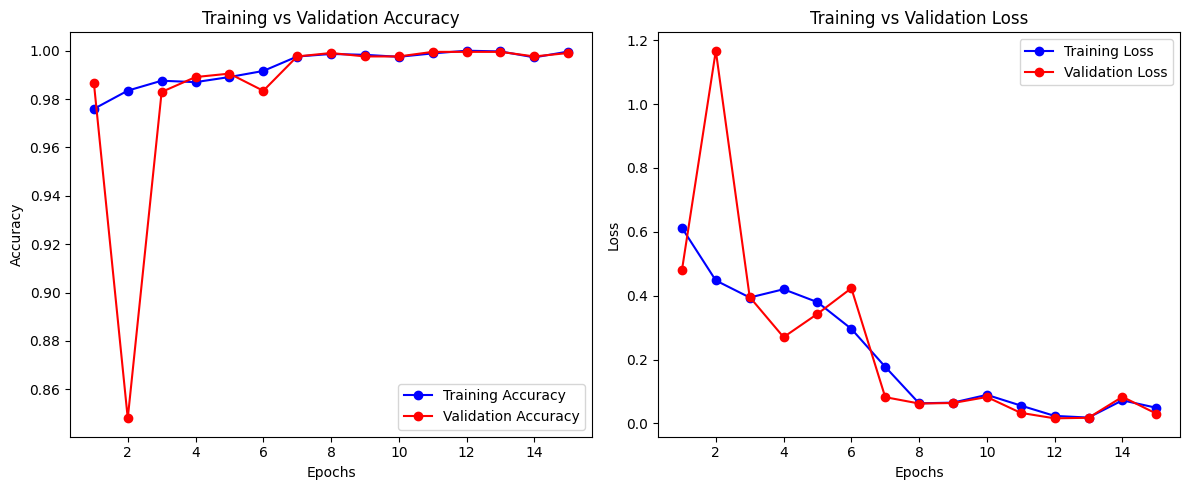

In [ ]:
# Visualization
acc = best_history.history["accuracy"]
val_acc = best_history.history["val_accuracy"]
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
n_epochs = range(1, len(loss) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(n_epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(n_epochs, loss, 'bo-', label='Training Loss')
plt.plot(n_epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **4. Evaluation**

In [204]:
test_ds = create_dataset(test_paths, y_test)

### **4.1. K-fold cross-validation model**

In [277]:
kfold_model = generate_model(**best_params)
kfold_model.load_weights(best_checkpoint_path)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [279]:
# Check for overfit
kfold_train = create_dataset(kfold_train_paths[1], kfold_y_train[1])
kfold_val = create_dataset(kfold_val_paths[1], kfold_y_val[1])
kfold_train_loss, kfold_train_acc = kfold_model.evaluate(kfold_train, steps=len(kfold_y_train[1])//64, verbose=1)
kfold_val_loss, kfold_val_acc = kfold_model.evaluate(kfold_val, steps=len(kfold_y_val[1])//64, verbose=1)
print(f"CV model's train accuracy: {kfold_train_acc:.4f}")
print(f"CV model's train loss: {kfold_train_loss:.4f}")
print(f"CV model's val accuracy: {kfold_val_acc:.4f}")
print(f"CV model's val loss: {kfold_val_loss:.4f}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - accuracy: 1.0000 - loss: 0.0109
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9981 - loss: 0.0136
CV model's train accuracy: 1.0000
CV model's train loss: 0.0108
CV model's val accuracy: 0.9995
CV model's val loss: 0.0123


In [ ]:
kfold_results = kfold_model.evaluate(test_ds, steps=len(y_test)//BATCH_SIZE, verbose=1)
print(f"CV model's test accuracy: {kfold_results[1]}")
print(f"CV model's test loss: {kfold_results[0]}")

CV model's test accuracy: 0.9977133870124817
CV model's test loss: 0.03012407198548317


In [ ]:
kfold_y_pred_probs = model.predict(test_ds, steps=len(y_test)//BATCH_SIZE, verbose=1)
kfold_y_pred = np.argmax(kfold_y_pred_probs, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


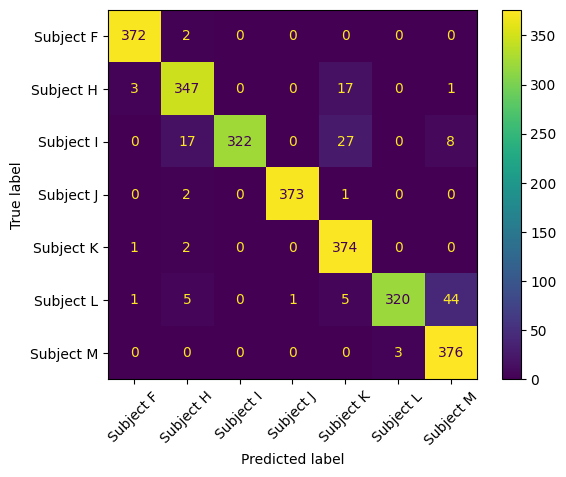

In [ ]:
# Confustion matrix
kfold_y_test=y_test[:len(kfold_y_pred)]
cm = confusion_matrix(kfold_y_test, kfold_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS)
disp.plot(cmap = "viridis")
plt.xticks(rotation=45) 
plt.show()

In [ ]:
# Classification report
report = classification_report(kfold_y_test, kfold_y_pred, target_names=CLASS_LABELS)
print(report)

              precision    recall  f1-score   support

   Subject F       0.99      0.99      0.99       374
   Subject H       0.93      0.94      0.93       368
   Subject I       1.00      0.86      0.93       374
   Subject J       1.00      0.99      0.99       376
   Subject K       0.88      0.99      0.93       377
   Subject L       0.99      0.85      0.92       376
   Subject M       0.88      0.99      0.93       379

    accuracy                           0.95      2624
   macro avg       0.95      0.95      0.95      2624
weighted avg       0.95      0.95      0.95      2624



In [242]:
# Architecture
kfold_model.summary()

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_124 (Conv2D)             │ (None, 18, 134, 64)    │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 18, 134, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_124               │ (None, 9, 67, 64)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 9, 67, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 9, 67, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_125               │ (None, 4, 33, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_62 (Flatten)            │ (None, 16896)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 128)            │     2,162,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,258,311 (8.61 MB)

 Trainable params: 2,257,927 (8.61 MB)

 Non-trainable params: 384 (1.50 KB)

## **4.2. Fully trained model**

In [271]:
# Load the dataset
final_train_ds = create_dataset(final_train_paths, y_final_train)
final_train_ds = final_train_ds.repeat()

In [ ]:
# Train the model
fully_trained_model = generate_model(**best_params)
final_path = os.path.join("classifiers\\models", "CNN_classifiers.weights.h5")
checkpoint = ModelCheckpoint(checkpoint_path,
                                monitor="loss",
                                save_best_only=True,
                                save_weights_only=True)

early_stop = EarlyStopping(monitor="loss", patience = 3, restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='loss',
                                 patience=2,
                                 verbose=0,
                                 factor=0.5,
                                 min_lr=0.00001)

history = fully_trained_model.fit(final_train_ds,
                                  epochs = 20,
                                  steps_per_epoch=len(y_final_train)//BATCH_SIZE,
                                  callbacks = [early_stop, lr_reduction, checkpoint], 
                                  verbose=1)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 337ms/step - accuracy: 0.7658 - loss: 2.8904 - learning_rate: 0.0010
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 353ms/step - accuracy: 0.9711 - loss: 0.7452 - learning_rate: 0.0010
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 346ms/step - accuracy: 0.9715 - loss: 0.6211 - learning_rate: 0.0010
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 99s 328ms/step - accuracy: 0.9832 - loss: 0.5394 - learning_rate: 0.0010
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - accuracy: 0.9839 - loss: 0.5106 - learning_rate: 0.0010
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - accuracy: 0.9888 - loss: 0.2950 - learning_rate: 0.0010
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.9873 - loss: 0.4801 - learning_rate: 0.0010
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9914 - loss: 0.2651 - learning_rate: 0.0010
Epoch 9/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - accuracy: 0.9951 - loss: 0.1908 - le

In [ ]:
fully_results = fully_trained_model.evaluate(test_ds, steps=len(y_test)//BATCH_SIZE, verbose=1)
print(f"Fully trained model's test accuracy: {fully_results[1]}")
print(f"Fully trained model's test loss: {fully_results[0]}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9966 - loss: 0.0581
Fully trained model's test accuracy: 0.9969512224197388
Fully trained model's test loss: 0.058374661952257156


In [ ]:
fully_y_pred_probs = fully_trained_model.predict(test_ds, steps=len(y_test)//BATCH_SIZE, verbose=1)
fully_y_pred = np.argmax(fully_y_pred_probs, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


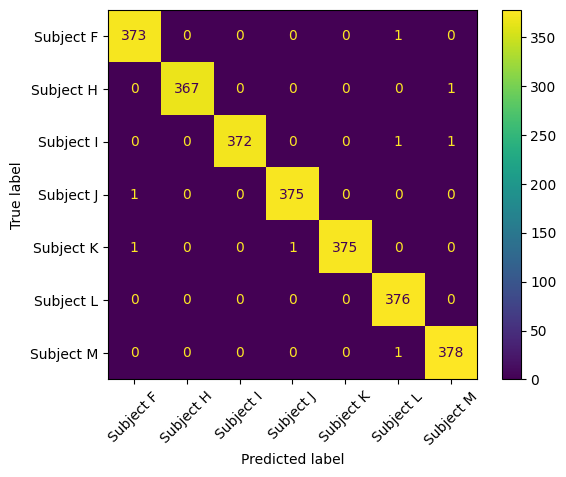

In [275]:
# Confustion matrix
fully_y_test=y_test[:len(fully_y_pred)]
cm = confusion_matrix(fully_y_test, fully_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS)
disp.plot(cmap = "viridis")
plt.xticks(rotation=45) 
plt.show()

In [276]:
report = classification_report(fully_y_test, fully_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      1.00      1.00       368
           2       1.00      0.99      1.00       374
           3       1.00      1.00      1.00       376
           4       1.00      0.99      1.00       377
           5       0.99      1.00      1.00       376
           6       0.99      1.00      1.00       379

    accuracy                           1.00      2624
   macro avg       1.00      1.00      1.00      2624
weighted avg       1.00      1.00      1.00      2624

